In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
import find_flies_in_image_directory
reload(find_flies_in_image_directory)
reload(find_flies_in_image_directory.rotate_fly_in_roi)

from multi_tracker_analysis import read_hdf5_file_to_pandas as mta_read

Using open cv: 3.3.1
Open CV 3


## Set the directory to a valid path

In [20]:
directory = '/media/caveman/FastData/all_colors/20171220_162257_N1_gphoto2'

## Get a reduced size grayscale median image, for finding flies 

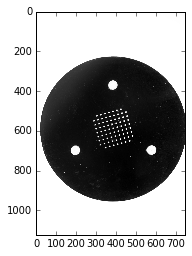

In [21]:
median = find_flies_in_image_directory.create_median_gray_small_image_from_directory(directory)

# show it
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(median, cmap='gray')

## Get a reduced size grayscale image with a fly in it (hopefully)

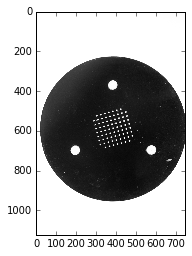

In [22]:
# get a list of all the fly images
file_list = mta_read.get_filenames(directory, '.jpg')

# load the first one
pixels_per_mm = 42
flyimg = find_flies_in_image_directory.FlyImg(directory, file_list[0], pixels_per_mm)
small_gray = flyimg.load_small_gray_image()

# show it
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(small_gray, cmap='gray')

## Find some flies and show them

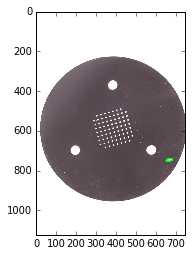

In [23]:
flyimg.find_flies(median)
flyimg.show_fly_ellipses()

## Get rois (region of interest) around each fly

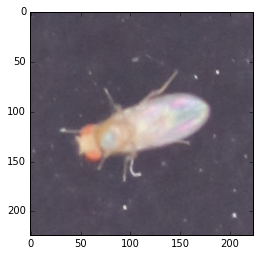

In [24]:
flyimg.load_rois_fly()
flyimg.show_rois()

## Get a full size color median image

In [25]:
median_large = find_flies_in_image_directory.create_median_image_from_directory(directory)

## Do all the above in function

In [56]:
def show_rois_for_image(n, directory, file_list, median):
    pixels_per_mm = 42
    flyimg = find_flies_in_image_directory.FlyImg(directory, file_list[n], pixels_per_mm)
    flyimg.find_flies(median)
    flyimg.load_rois_fly(width=150)
    flyimg.load_rois_median(median_large, width=150)
    flyimg.load_rois_isolated_fly()
    
    # show the results
    flyimg.show_rois()
    flyimg.show_rois(flyimg.rois_isolated_fly)
    
    return flyimg

0.0 0.0229555555556


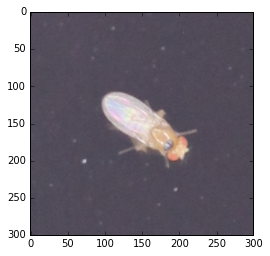

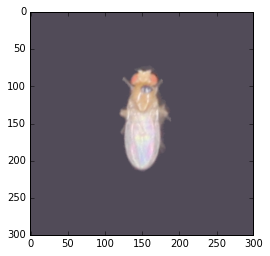

In [110]:
flyimg = show_rois_for_image(290, directory, file_list, median)

In [112]:
f = flyimg.rois_isolated_fly[0]

In [113]:
c = f[90:120, 125:175]

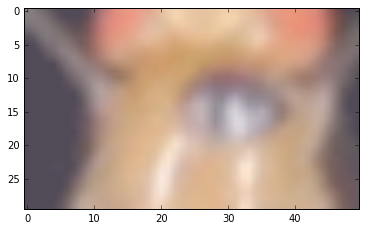

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(flyimg.convert_bgr_to_rgb(c))

In [115]:
import cv2

In [116]:
hsv = cv2.cvtColor(c,cv2.COLOR_BGR2HSV)

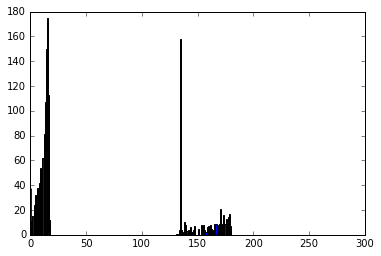

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist( np.ravel(hsv[:,:,0]), bins=np.arange(0,255))

In [120]:
def align_two_flies(im1, im2, im2_ellipse=None, conversion_to_BGR=None):
    rows,cols,channels = im2.shape

    if im2_ellipse is not None:
        ellipse = ((im2.shape[0], im2.shape[1]), (im2_ellipse[1][0], im2_ellipse[1][1]), 0)
        median_value = find_median_background_value_for_roi(im2, im2_ellipse)

    # Find size of image1
    sz = im1.shape

    if conversion_to_BGR is not None:
        im1_ = cv2.cvtColor(im1,conversion_to_BGR)
        im2_ = cv2.cvtColor(im2,conversion_to_BGR)
    else:
        im1_ = im1
        im2_ = im2

    im1_gray = cv2.cvtColor(im1_,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2_,cv2.COLOR_BGR2GRAY)

    # if the image is more white than black, invert it, because new pixels are black
    if np.median(im1_gray) > 125:
        im1_gray = 255 - im1_gray
    im1_gray -= np.min(im1_gray)

    if np.median(im2_gray) > 125:
        im2_gray = 255 - im2_gray
    im2_gray -= np.min(im2_gray)

    # Define the motion model
    warp_mode = cv2.MOTION_HOMOGRAPHY

    # Define 3x3 matrices and initialize the matrix to identity
    warp_matrix = np.eye(3, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 100;
    
    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)


    # Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

    # set the outer circle to median background color
    if im2_ellipse is not None:
        mask_circle = np.ones_like(im2_aligned)
        r = int(im2_aligned.shape[0]/2.)
        r_buffer = int(r*2*0.2)
        zero_centered_ellipse = ((r, r), (r*2-r_buffer, r*2-r_buffer), 0) # the minus 5 deals with fringe pixels
        cv2.ellipse(mask_circle,zero_centered_ellipse,0,-1)

        im2_aligned = im2_aligned*(1-mask_circle) + (mask_circle*median_value).astype(np.uint8)

    return im2_aligned

In [119]:
im1 = cv2.imread('/media/caveman/FastData/test/model/20171220_222037_N1_1513837237_431376934_0.jpg')
im2 = cv2.imread('/media/caveman/FastData/test/model/20171220_222110_N1_1513837270_789792060_0.jpg')

In [121]:
im2_aligned = align_two_flies(im1, im2)

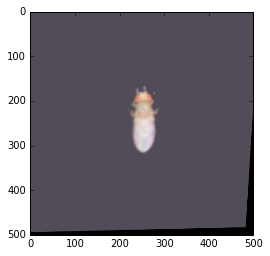

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2RGB))
